# DEFINITION OF FUNCTIONS
* For plotting a map

In [1]:
def plot_map(X, Y, data, title, xlabel, ylabel, title_colorbar, path_save, title_save):
        '''
        Function for plotting a map.
        
        Args :  
        X, Y, data, title, xlabel, ylabel, title_colorbar, path_save, title_save 
        '''
        import matplotlib.pyplot as plt
        import numpy as np
            
        plt.figure()
        plt.contourf(X, Y, data, levels=np.linspace(-2,2,50))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        c=plt.colorbar()
        c.set_label(title_colorbar)
        plt.savefig(path_save + title_save)

* For plotting a map in polar projection

In [2]:
def polar_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a polar projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        # levels
        v       = cbar_levels
            
        # figure 
        fig     = plt.figure(figsize=(10,10))
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0)#, resolution="f")
        xm, ym  = m(X, Y)
        #im      = m.pcolor(xm, ym, data, cmap=cmap)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        # colorbar 
        cbar = m.colorbar(im,pad='20%')
        cbar.set_label(title_colorbar, fontsize =16)

        # structure
        m.fillcontinents(color='0.5', lake_color='0.5')
        par = m.drawparallels(np.arange(-90., -30., 20.))#,labels=[True, False, True, True])
        m.drawmeridians(np.arange(0., 360., 30.), labels=[1, 1, 1, 1]) 
        #m.drawcoastlines()
        #plt.clabel(par, inline=True, fontsize=13, fmt='%i') 

            
        plt.title(title,fontsize=18, y=1.08)
        plt.savefig(path_save + title_save, bbox_inches='tight')

* Function to interpolate bathymetry grid to my data grid in order to then create a mask for topography >= 0 with :

    etopo_interp = interp_etopo('/project_shared/ETOPO/ETOPO1_Ice_g_gmt4.grd', 'x', 'y', 'z', 1, XC, YC)

    ssh_new = np.ma.masked_where(etopo_interp>=0, mean_ssh_model)

In [3]:
def interp_etopo(tfile, lon_topo, lat_topo, z_topo, sub, lon_grid, lat_grid):
    '''
    Function to interpolate bathymetry grid to my data grid in order to then create a mask for topography >= 0 
    
    Args : tfile (file of topo/bathymetry), lon_topo, lat_topo, z_topo, sub (step used to select only part of 
    the data, lon_grid (lon of grid of our data on which we wish to interpolate topo), lat_grid (same).
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from netCDF4 import Dataset, num2date
    
    etopo = Dataset(tfile, 'r')
    lats = etopo.variables[lat_topo][::sub] # selectes lats with a step of sub (to select all choose sub = 1)
    lons = etopo.variables[lon_topo][::sub]
    z = etopo.variables[z_topo][::sub,::sub]
    if ((lons >= -180.).all() and (lons <= 180.).all()): # .all() gets rid of Falses, only keeps Trues
        lon0 = np.where(lons>=0)[0][0] # to change lons from (-180, 180) to (0, 360)
        lons = lons + 180
        topo = z.copy()
        tmp = z[0,lon0:].shape[0]
        topo[:,:tmp] = z[:,lon0:]
        topo[:,tmp:] = z[:,:lon0]
    else: 
        topo = z.copy()

    grid = interpolate.interp2d(lons, lats, topo, kind='linear') # interpolates the topo to the grid of the data
    lon, lat = lon_grid, lat_grid
    etopo_interp = grid(lon, lat)
    return etopo_interp

In [4]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [5]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=lon[0],llcrnrlat=lat[0],urcrnrlon=lon[-1],urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=70.,lon_0=-185.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()



        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

***

# CODE

* Loads data
* Calculates variables

In [6]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

***

# - AVISO DATA

In [7]:
# Read data and change from .mat to numpy array
f = h5py.File(load_path + 'aviso_tot_MADT_sose_6Apr2006to5Apr2011.mat','r')

# Latitude and longitude variables
xsave = f.get('xsave')
xsave = np.array(xsave)
ysave = f.get('ysave')
ysave = np.array(ysave)

# Get rid of dimension 1 (go from 2D to 1D)
xsave = np.squeeze(xsave)
ysave = np.squeeze(ysave)

In [8]:
# Read data and change from .mat to numpy array
f = h5py.File(load_path + 'aviso_tot_MADT_sose_6Apr2006to5Apr2011.mat','r')

# Latitude and longitude variables
xsave = f.get('xsave')
xsave = np.array(xsave)
ysave = f.get('ysave')
ysave = np.array(ysave)
tsave = f.get('tsave')
tsave = np.array(tsave)

# Get rid of dimension 1 (go from 2D to 1D)
xsave = np.squeeze(xsave)
ysave = np.squeeze(ysave)
tsave = np.squeeze(tsave)
#ysave = ysave[:194]

# Create grid for lat (Xa) and lon (Ya)
Xa, Ya = np.meshgrid(xsave, ysave)

In [ ]:
# Extract of data
dsave = f.get('dsave')
dsave = np.array(dsave)
dsave = np.moveaxis(dsave, 2, 0)
dsave = np.moveaxis(dsave, 2, 1)

# Transpose the matrices before plotting
#Xa=Xa.transpose()
#Ya=Ya.transpose()

In [ ]:
# Calculate mean SSH
mean_ssh_a = np.nanmean(dsave, axis=0)

# Calculate de standard deviation of SSH
std_a = np.nanstd(dsave, axis=0)

### Interpolation of bathymetry/topography on AVISO grid

In [12]:
# ETOPO file
tfile = '/project_shared/ETOPO/ETOPO1_Ice_g_gmt4.grd'

# Interpolation of bathymetry on AVISO grid
etopo_interp = interp_etopo(tfile=tfile, lon_topo='x', lat_topo='y', z_topo='z', sub=4, lon_grid=xsave, lat_grid=ysave)

<matplotlib.contour.QuadContourSet instance at 0x18d249e0>

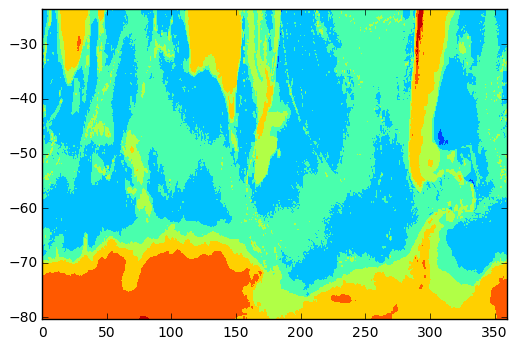

In [21]:
plt.contourf(xsave, ysave, etopo_interp)

### Land mask : creating a mask for topography >=0 thanks to the interpolation

In [38]:
# Applying a mask to the mean and std deviation matrices
mean_ssh_aviso = np.ma.masked_where(etopo_interp>=0, mean_ssh_a)
std_aviso = np.ma.masked_where(etopo_interp>=0, std_a)

### Taking into account the area of each grid cell of AVISO data

In [39]:
# Taking into account the area of each cell which increases with latitude
cell_area = 0.25*0.25*cos(ysave*pi/180)# dx*dy*cos(lat), 0.25 = 1/4 of degree --> resolution of AVISO
    
dsave2 = np.moveaxis(dsave, 2, 1)
weight = dsave2*cell_area

weight_mean_aviso = np.nansum(weight, axis=0)/(cell_area*len(tsave))
weight_mean_aviso = weight_mean_aviso.T

# LAND MASK
weight_mean_aviso = np.ma.masked_where(etopo_interp>=0, weight_mean_aviso)

## How many days of data for each grid cell ?

In [9]:
count=np.zeros((len(ysave), len(xsave)))
for t in range(len(tsave)):
    for i in range(len(ysave)):
        for j in range(len(xsave)):
            if np.isnan(dsave[t,i,j]):
                count[i,j]=count[i,j]
            else:
                count[i,j]=count[i,j]+1

count=np.ma.masked_array(count)
count=np.ma.masked_where(count==0, Count)

In [35]:
pickle_save('count', '/data/ebent', count)

('saved at : ', '/data/ebent/count.npy')


In [9]:
count = pickle_load('count', '/data/ebent')

('loaded from : ', '/data/ebent/count.npy')


In [10]:
count = count*100/count.max()

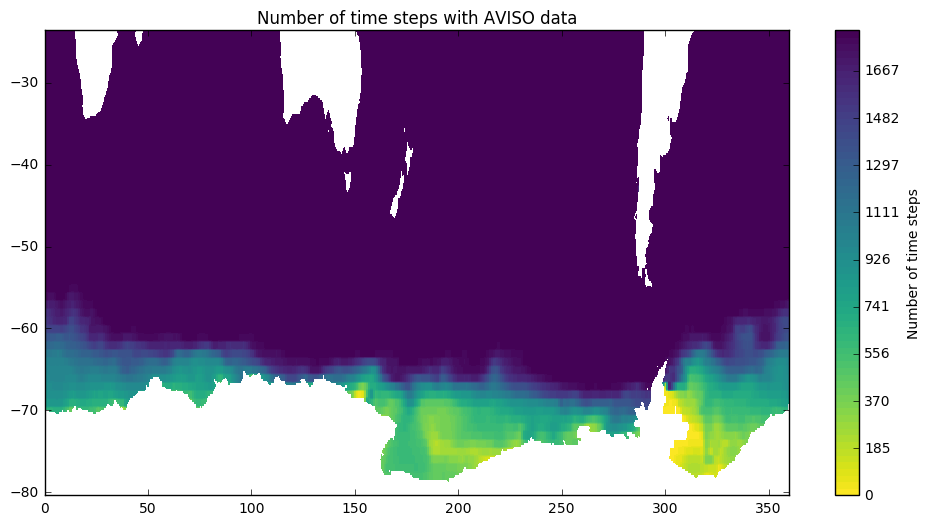

In [44]:
plt.figure(figsize=(12,6))
plt.contourf(Xa, Ya, count, levels=np.linspace(0, 1826, 70), cmap='viridis_r')
plt.title('Number of time steps with AVISO data')
c=plt.colorbar()
c.set_label('Number of time steps')
plt.savefig(plot_path_jup + 'time_steps_aviso_jup.png')

In [13]:
import cmocean

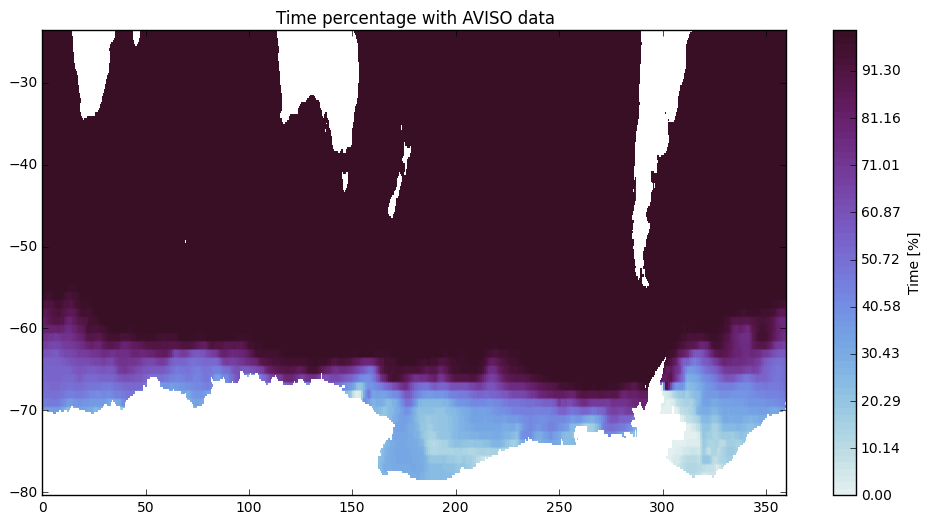

In [16]:
plt.figure(figsize=(12,6))
plt.contourf(Xa, Ya, count, levels=np.linspace(0, 100, 70), cmap=cmocean.cm.dense)
plt.title('Time percentage with AVISO data')
c=plt.colorbar()
c.set_label('Time [%]')
plt.savefig(plot_path_jup + 'time_steps_aviso_jup.png')

***

# - MODEL

In [9]:
# Read data as netCDF file
f = netCDF4.Dataset(load_path2+'SO12_Dec17_2005toAp2011_5day_SSH.nc','r')

# Latitude and longitude variables
XC=f.variables['XC'][:]
YC=f.variables['YC'][:]

# Extract of data
time=f.variables['time'][91:-1]
ssh=f.variables['ETAN'][91:-1]
area=f.variables['rA'][:]

# Create grid for lat (Xm) and lon (Ym)
Xm, Ym = np.meshgrid(XC, YC) 

# Calculate mean SSH
#mean_ssh_m = np.ma.mean(ssh, axis=0)

# Calculate de standard deviation of SSH
#std_m = np.ma.std(ssh, axis=0)

In [10]:
XC[0], XC[-1], YC[0], YC[-1]

(0.041666668, 359.95834, -77.991333, -30.053228)

<matplotlib.contour.QuadContourSet instance at 0x1b942710>

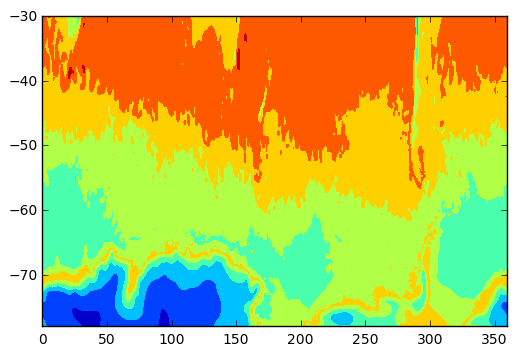

In [24]:
plt.contourf(Xm, Ym, ssh[0,...])

<matplotlib.contour.QuadContourSet instance at 0x1b70d248>

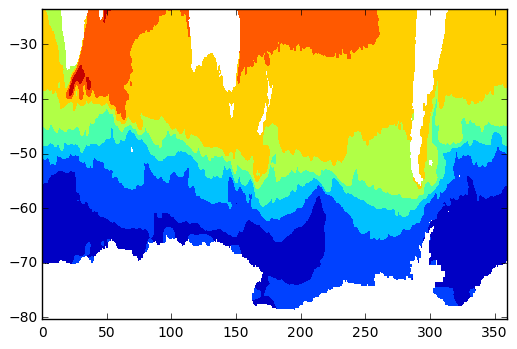

In [30]:
plt.contourf(Xa, Ya, mean_ssh_aviso)

***

## Interpolation of the whole model output on AVISO grid

Create fonction 'grid' that takes the lat and lon vectors of a data matrice and interpolates with new lat and lon when function 'grid' is called



In [42]:
ssh_interp = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for t in range(len(time)):
    gridd = interpolate.interp2d(XC, YC, ssh[t], kind='linear') # XC and YC are lat and lon vectors of model
    ssh_interp[t] = gridd(xsave, ysave)

ssh_interp is the model output interpolated to the AVISO grid

### We calculate again the new mean for SSH of model once interpolated (once plotted, looks exactly the same as mean_ssh_model and std_model)

mean_ssh_interp = np.ma.mean(ssh_interp, axis=0)
std_interp = np.ma.std(ssh_interp, axis=0)

***

# Ice mask for model

Calculate the mean of dsave (AVISO) every 5 time steps to be same size as ssh (model) and to be able to do ice mask

In [43]:
dsave_5 = np.ma.masked_all((365, len(ysave), len(xsave)))
a = 0
b = 5
for c in range(365):
    #print(c)
    #print(a,b)
    dsave_5[c]= np.nanmean(dsave[a:b], axis=0)
    a+=5
    b+=5
dsave_5[-1,:,:]=dsave_5[-2,:,:]

In [44]:
ssh_ice_mask = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for l in range(len(time)):
    ssh_ice_mask[l] = np.ma.masked_where(np.isnan(dsave_5[l]), ssh_interp[l])

In [45]:
mean_ssh_ice = np.ma.mean(ssh_ice_mask, axis=0)
std_ice = np.ma.std(ssh_ice_mask, axis=0)

***

# Land mask for the model

We extract hFacC which is the fraction of cell of water (thickness), if hFacC==0 there is no water, if hFacC==1 the cell is full of water

In [7]:
file = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file.get('hFacC')
hFacC = np.array(hFacC)
Xf = file.get('XC')
Xf = np.array(Xf)
Yf = file.get('YC')
Yf = np.array(Yf)
RC = file.get('RC')
RC = np.array(RC)
z = np.squeeze(RC)

x = Xf[0,:]
y = Yf[:,0]

In [14]:
x[0], x[-1], y[0], y[-1]

(0.041666668, 359.95834, -77.991333, 2.5466681)

In [13]:
hFacC.shape, Xf.shape, Yf.shape

((104, 1260, 4320), (1260, 4320), (1260, 4320))

hFacC[0,:,:] corresponds to the layer at the surface (z = -1), we interpolate it to the AVISO grid

In [15]:
griD = interpolate.interp2d(x, y, hFacC[0,:,:], kind='linear') # XC and YC are lat and lon vectors of model
hFacC_interp = griD(xsave, ysave)

<matplotlib.contour.QuadContourSet instance at 0x194b36c8>

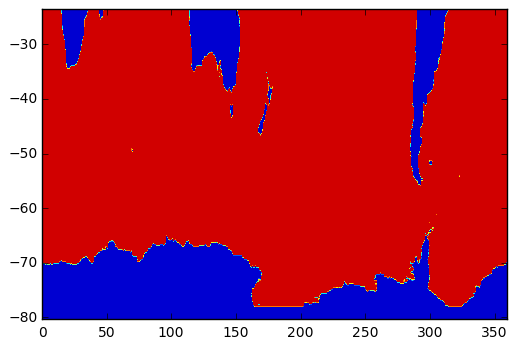

In [20]:
plt.contourf(xsave, ysave, hFacC_interp)

We apply a land mask to the model 

In [48]:
# Applying a mask to the mean and std deviation matrices
mean_ssh_model = np.ma.masked_where(hFacC_interp==0, mean_ssh_ice)
std_model = np.ma.masked_where(hFacC_interp==0, std_ice)

***

# Taking into account the area of each grid cell of model

In [49]:
# Taking into account the area of each cell which increases with latitude
weight_ssh = ssh*area

# Interpolate area to AVISO grid
griddd = interpolate.interp2d(XC, YC, area, kind='linear')
area_interp = griddd(xsave, ysave)

# Interpolate weight_ssh to AVISO grid
weight_ssh_interp = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for t in range(len(time)):
    gridd = interpolate.interp2d(XC, YC, weight_ssh[t], kind='linear') # XC and YC are lat and lon vectors of model
    weight_ssh_interp[t] = gridd(xsave, ysave)

# ICE MASK
weight_ice_mask = np.ma.masked_all((len(time), len(ysave), len(xsave)))
for l in range(len(time)):
    weight_ice_mask[l] = np.ma.masked_where(np.isnan(dsave_5[l]), weight_ssh_interp[l])

# Calculate the mean    
weight_mean_model = np.ma.sum(weight_ssh_interp, axis=0)/(area_interp*len(time))

# LAND MASK
weight_mean_model = np.ma.masked_where(hFacC_interp==0, weight_mean_model)

***

# Save variables in netCDF files

## Model

In [60]:
nc = netCDF4.Dataset('model_enreg.nc', 'w', format='NETCDF4')
nc.title = 'Model  variables : std, mean'
from datetime import datetime
nc.date_created = datetime.now().isoformat()

nc.createDimension('lat', len(ysave))
nc.createDimension('lon', len(xsave))

std = nc.createVariable('std_model', 'f', ('lat','lon'))
std.long_name = 'Standard deviation of SSH of Model'
std[:] = std_model

mean = nc.createVariable('mean_model', 'f', ('lat','lon'))
mean.long_name = 'Mean SSH of Model'
mean[:] = mean_ssh_model

mean_weight = nc.createVariable('weight_mean_model', 'f', ('lat','lon'))
mean_weight.long_name = 'Mean SSH of Model weighted by area of each grid cell'
mean_weight[:] = weight_mean_model

nc.close()

## AVISO

In [61]:
nc = netCDF4.Dataset('aviso_enreg.nc', 'w', format='NETCDF4')
nc.title = 'AVISO variables : std, mean, Xa, Ya, count_data'
from datetime import datetime
nc.date_created = datetime.now().isoformat()

nc.createDimension('lat', len(ysave))
nc.createDimension('lon', len(xsave))
nc.createDimension('time_model', 365)

std = nc.createVariable('std_aviso', 'f', ('lat','lon'))
std.long_name = 'Standard deviation of SSH of AVISO data'
std[:] = std_aviso

mean = nc.createVariable('mean_aviso', 'f', ('lat','lon'))
mean.long_name = 'Mean SSH of AVISO data'
mean[:] = mean_ssh_aviso

mean_weight = nc.createVariable('weight_mean_aviso', 'f', ('lat','lon'))
mean_weight.long_name = 'Mean SSH of AVISO data weighted by area of each grid cell'
mean_weight[:] = weight_mean_aviso

X = nc.createVariable('Xa', 'f', ('lat','lon'))
X.long_name = 'Longitude meshgrid'
X[:] = Xa

Y = nc.createVariable('Ya', 'f', ('lat','lon'))
Y.long_name = 'Latitude meshgrid'
Y[:] = Ya


dsave_5 = nc.createVariable('dsave_5', 'f', ('time_model', 'lat', 'lon'))
dsave_5.long_name = 'AVISO selected every 5 time step to have time same size as model'
dsave_5[:] = dsave_5
'''
count_data = nc.createVariable('count', 'f', ('lat','lon'))
count_data.long_name = 'Count how many time steps of data on each grid cell'
count_data[:] = count
'''
nc.close()

# Read variables

#### Load ALL of data (run cell bellow) for plotting ORTHO maps

In [9]:
f1 = netCDF4.Dataset('aviso_enreg.nc', 'r', format='NETCDF4')
mean_ssh_aviso = f1.variables['mean_aviso'][:]
weight_mean_aviso = f1.variables['weight_mean_aviso'][:]
std_aviso = f1.variables['std_aviso'][:]
Ya = f1.variables['Ya'][:]
Xa = f1.variables['Xa'][:]


f2 = netCDF4.Dataset('model_enreg.nc', 'r', format='NETCDF4')
mean_ssh_model = f2.variables['mean_model'][:]
weight_mean_model = f2.variables['weight_mean_model'][:]
std_model = f2.variables['std_model'][:]

In [89]:
# Difference between mean SSH of data and model
diff = mean_ssh_aviso-mean_ssh_model

Offset from -66 to -40

In [93]:
print ysave[57], ysave[161] # add +1 in the crop !!!!

-66.125 -40.125


In [ ]:
# Calculate difference between -40 and -66
diff_weight = weight_mean_aviso[57:162]-weight_mean_model[57:162]

In [94]:
# Calculate the offset : mean_diff
mean_diff_weight = np.nanmean(diff_weight)

In [95]:
print mean_diff_weight

0.464096


#### Read JUST until -40 of latitude to avoid weird red part of map that is above this lat (run cell bellow)

In [9]:
print ysave[57], ysave[161]

-66.125 -40.125


In [9]:
f1 = netCDF4.Dataset('aviso_enreg.nc', 'r', format='NETCDF4')
mean_ssh_aviso = f1.variables['mean_aviso'][:162,:]
weight_mean_aviso = f1.variables['weight_mean_aviso'][:162,:]
std_aviso = f1.variables['std_aviso'][:162,:]
Ya = f1.variables['Ya'][:162,:]
Xa = f1.variables['Xa'][:162,:]


f2 = netCDF4.Dataset('model_enreg.nc', 'r', format='NETCDF4')
mean_ssh_model = f2.variables['mean_model'][:162,:]
weight_mean_model = f2.variables['weight_mean_model'][:162,:]
std_model = f2.variables['std_model'][:162,:]

In [10]:
# Difference between mean SSH of data and model
diff = mean_ssh_aviso-mean_ssh_model

Offset from -66 to -40

In [11]:
# Calculate difference between -40 and -66
diff_weight = weight_mean_aviso[57:]-weight_mean_model[57:]

In [12]:
# Calculate the offset : mean_diff
mean_diff_weight = np.nanmean(diff_weight)

In [13]:
print mean_diff_weight

0.464096


***

***

# PLOTS

## - AVISO data

Mean

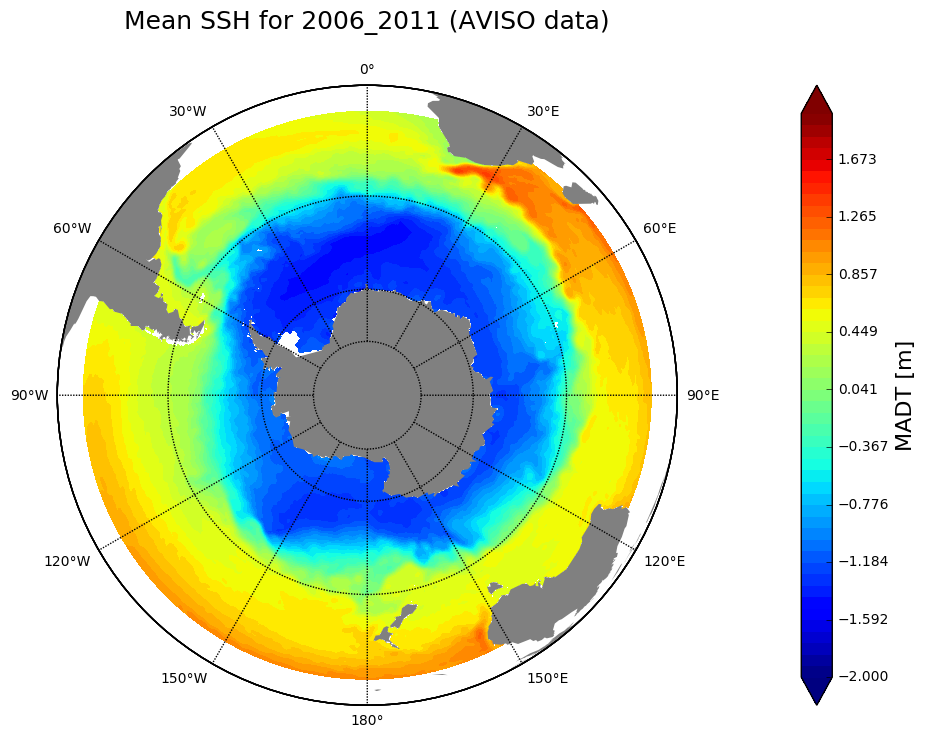

In [50]:
# Plot the mean SSH
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_aviso, 'Mean SSH for 2006_2011 (AVISO data)', 'MADT [m]', plt.cm.jet, plot_path_jup, 'aviso_polar_mean_ssh_jup.png') 

Standard deviation

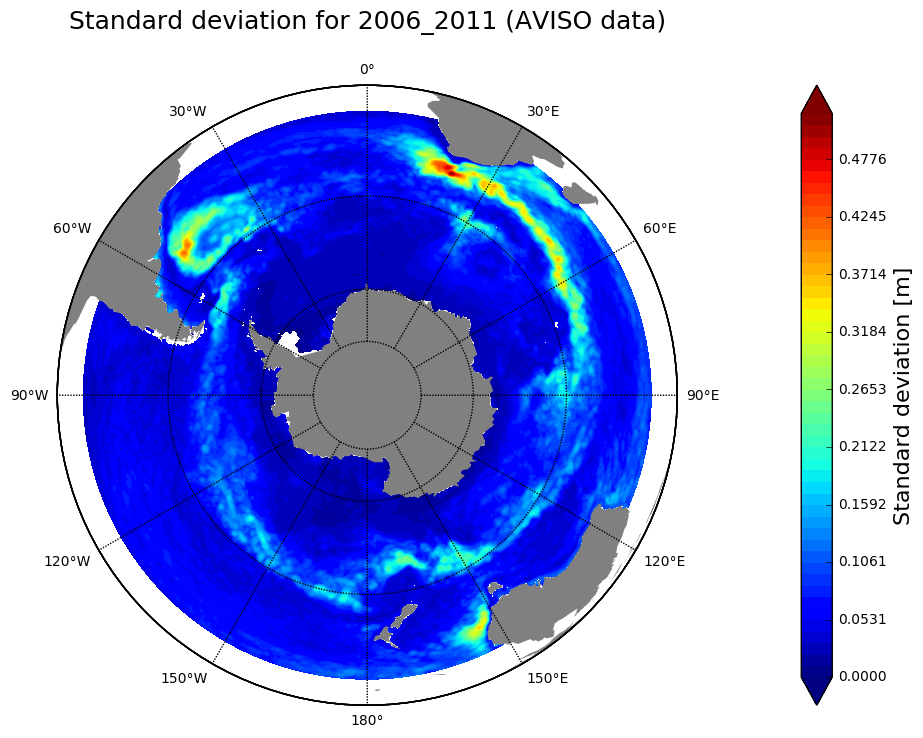

In [51]:
# Plot the standard deviation
polar_map(np.linspace(0, 0.52, 50), Xa, Ya, std_aviso, 'Standard deviation for 2006_2011 (AVISO data)', 'Standard deviation [m]', plt.cm.jet, plot_path_jup, 'aviso_std_jup.png')

## - Model

Mean

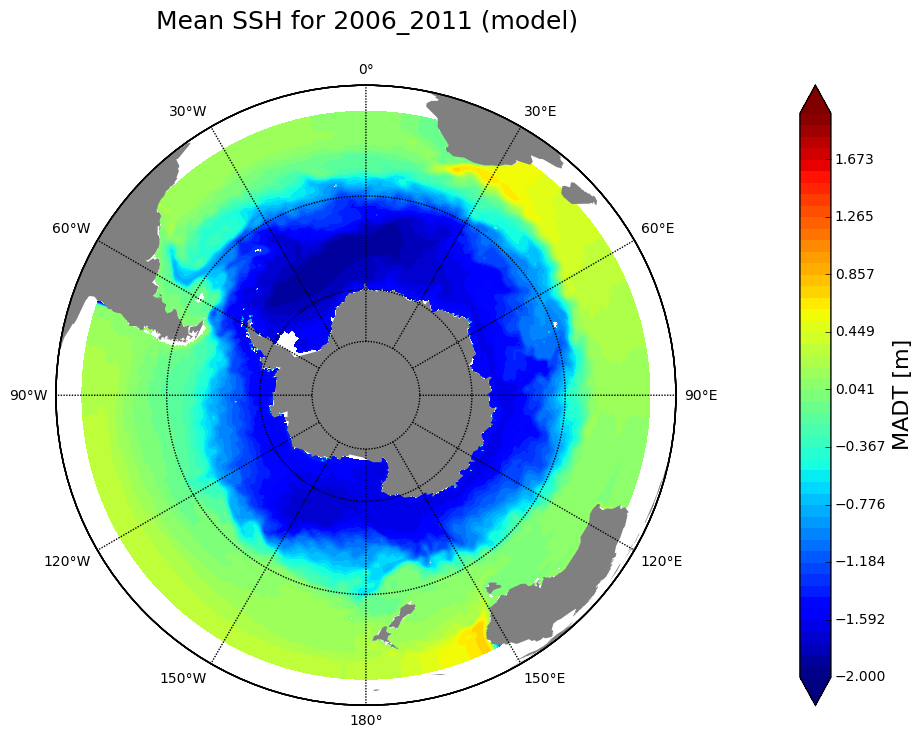

In [91]:
# Plot the mean SSH
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_model, 'Mean SSH for 2006_2011 (model)', 'MADT [m]', plt.cm.jet, plot_path_jup, 'model_polar_mean_ssh_jup.png') 

Standard deviation

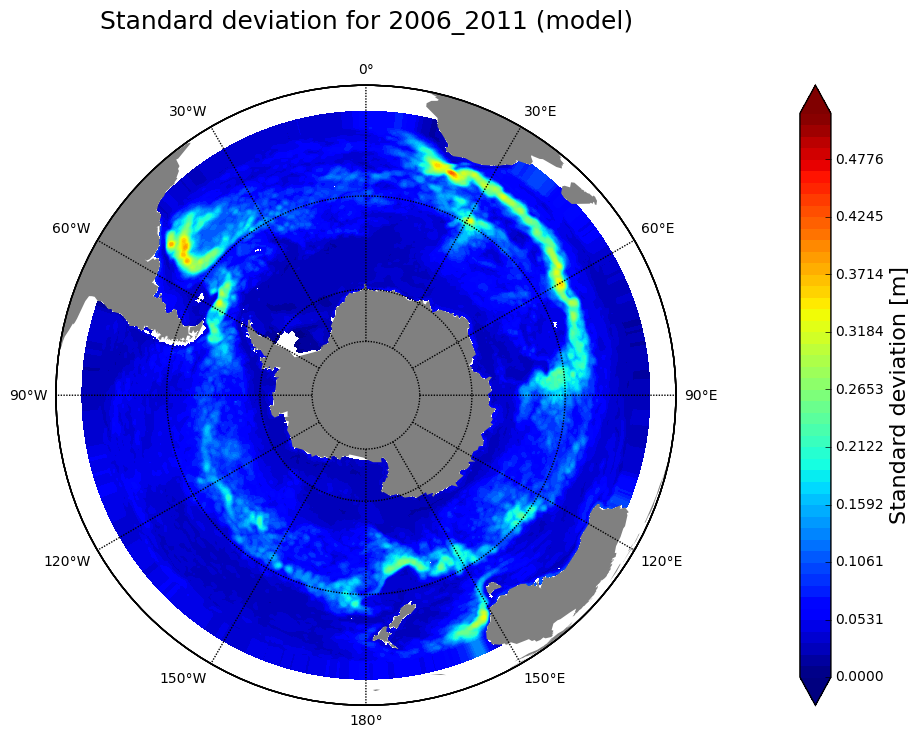

In [92]:
# Plot the standard deviation
polar_map(np.linspace(0, 0.52, 50), Xa, Ya, std_model, 'Standard deviation for 2006_2011 (model)', 'Standard deviation [m]', plt.cm.jet, plot_path_jup, 'model_std_jup.png')

# Plot of the mean SSH of the model + difference between mean SSH of data and model

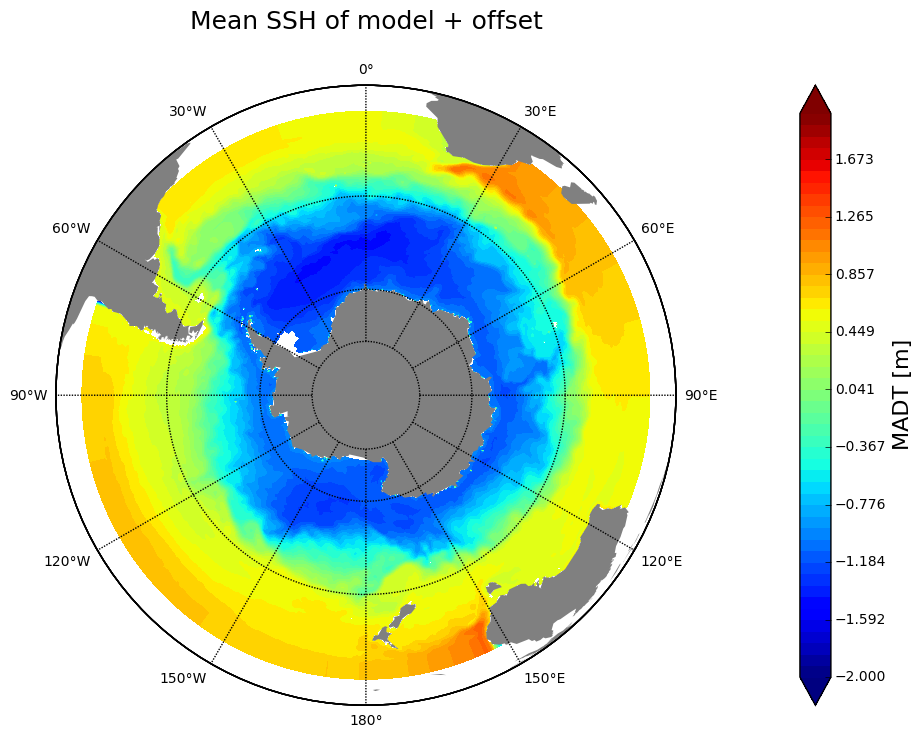

In [86]:
polar_map(np.linspace(-2,2,50), Xa, Ya, mean_ssh_model+mean_diff_weight, 'Mean SSH of model + offset', 'MADT [m]', plt.cm.jet, plot_path_jup, 'offset+model_jup.png')

# Plot of the difference of the mean SSH between the model and data - mean of this difference

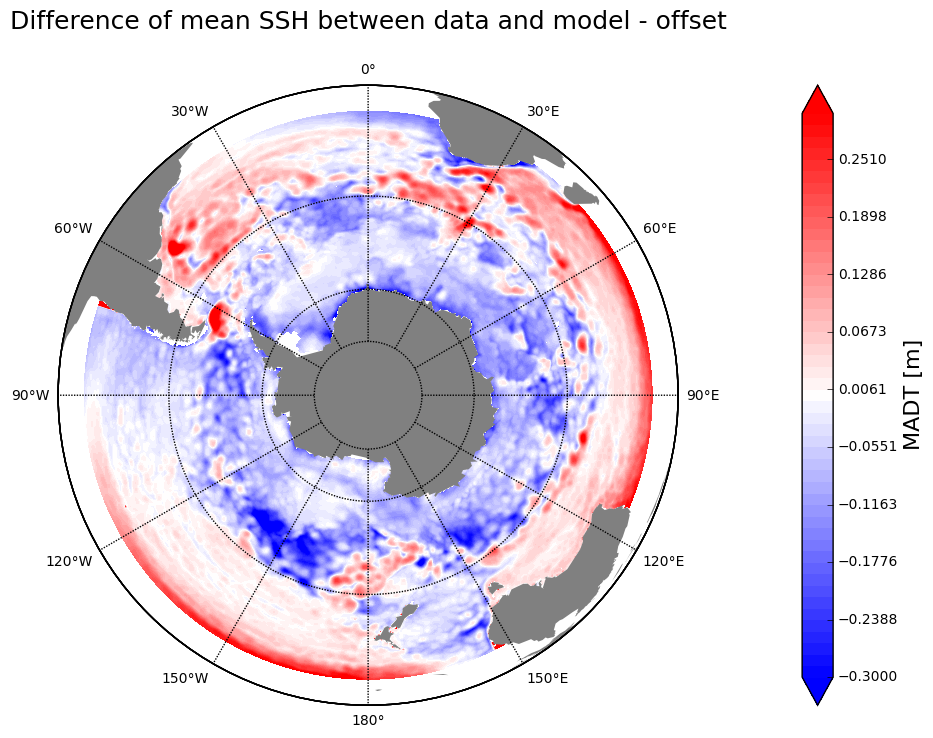

In [90]:
polar_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Difference of mean SSH between data and model - offset', 'MADT [m]', plt.cm.bwr, plot_path_jup, 'diff-offset_bwr_jup.png')

***

# Working on plot for poster

In [14]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [15]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"
lon_min   = 1440 
lon_max   = 3241
lat_min   = 0 
lat_max   = 1024

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04
XC, YC    = np.meshgrid(XC, YC)

In [16]:
southern_front = pickle_load('ACC_southern_front', '/data/ebent/', verbose=False)
southern_front = np.ma.masked_array(southern_front, mask=False)

In [17]:
W_boundary = 12 # 121,04 degrees
E_boundary = 1560 # 250,04 degrees

In [18]:
look_index = np.where(southern_front[:,W_boundary]==0)[0]
look_index2 = np.where(southern_front[:,E_boundary]==0)[0]
tmp = np.ones(look_index[0])*W_boundary
tmp2 = np.ones(look_index2[0])*E_boundary

In [41]:
def merc_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        
        fig     = plt.figure(figsize=(30,(30./190.)*53))
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(12,12))
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-40.,\
                  llcrnrlon=120.,urcrnrlon=270.,lat_ts=-60.,resolution='l')
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im, pad='2%', size='3%', ticks=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
        cbar.set_label(title_colorbar, fontsize=20)
        bounds = ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3']
        cbar.ax.set_yticklabels(bounds)
        
        m.fillcontinents(color='k', lake_color='k')
        m.drawparallels(np.arange(-80.,-20.,10), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(120.,301.,60), labels=[0, 0, 0, 1], labelstyle='+/-')
        m.drawcoastlines()

        # Plot the southern front
        xm, ym  = m(XC[:,W_boundary:E_boundary], YC[:,W_boundary:E_boundary])
        im      = m.contour(xm, ym, southern_front[:,W_boundary:E_boundary], colors='m', linewidths=4)
        
        # Plot the E_boundary and W_boundary
        xm, ym  = m(XC[:660,W_boundary], YC[:look_index[0],0])
        m.plot(xm, ym, '-', color='m', linewidth=4)
        
        xm, ym  = m(XC[:557,E_boundary], YC[:look_index2[0],0])
        m.plot(xm, ym, '-', color='m', linewidth=4)
        plt.title(title, fontsize=22, y=1.02)
        #plt.title(title, fontsize=26, y=1.02)
        plt.savefig(path_save + title_save, bbox_inches='tight', dpi=300)#, format='pdf') #  dpi=1000,

Offset from -66 to -40

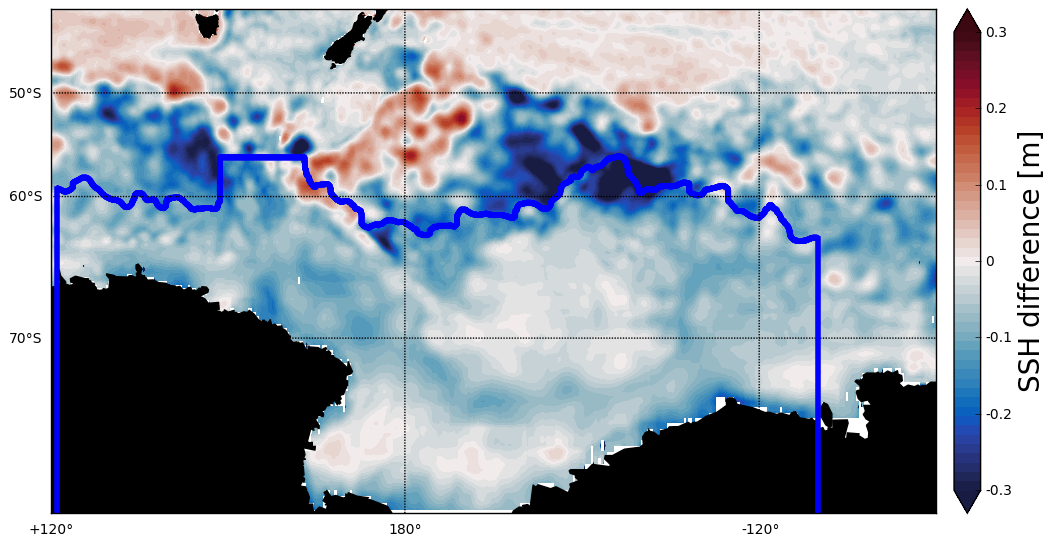

In [39]:
merc_map(np.linspace(-0.3,0.3,50), Xa, Ya, diff-mean_diff_weight, 'Mean SSH difference', 'SSH difference [m]', cmocean.cm.balance, '/home/ebent/Final_figs/', 'diff_ssh.png')

In [17]:
(diff-mean_diff_weight).max()

0.52310342

In [18]:
(diff-mean_diff_weight).min()

-1.3939028

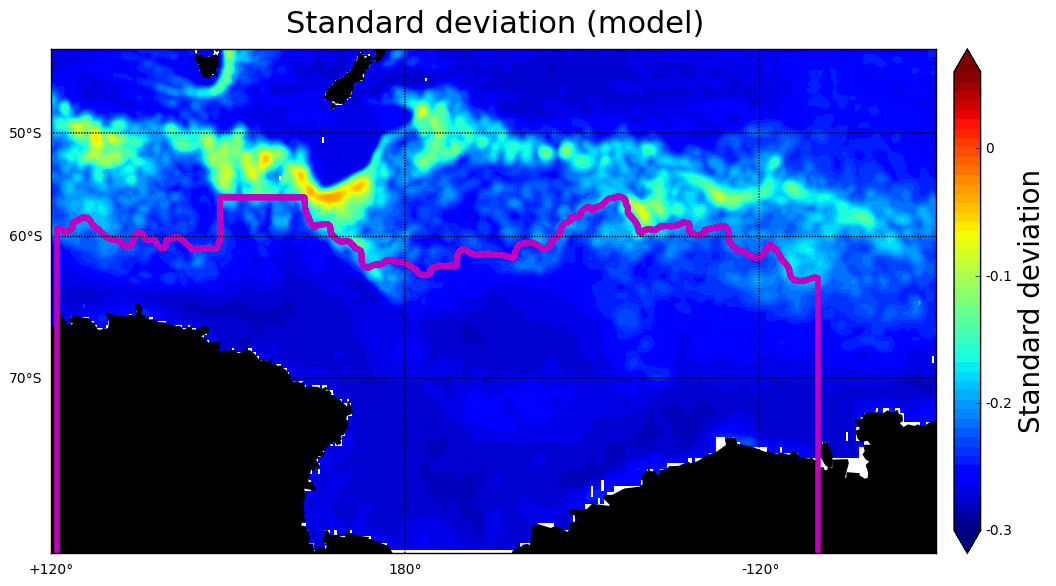

In [44]:
merc_map(np.linspace(0, 0.36, 50), Xa, Ya, std_model, 'Standard deviation (model)', 'Standard deviation', plt.cm.jet, '/home/ebent/Final_figs/', 'std_model.png')

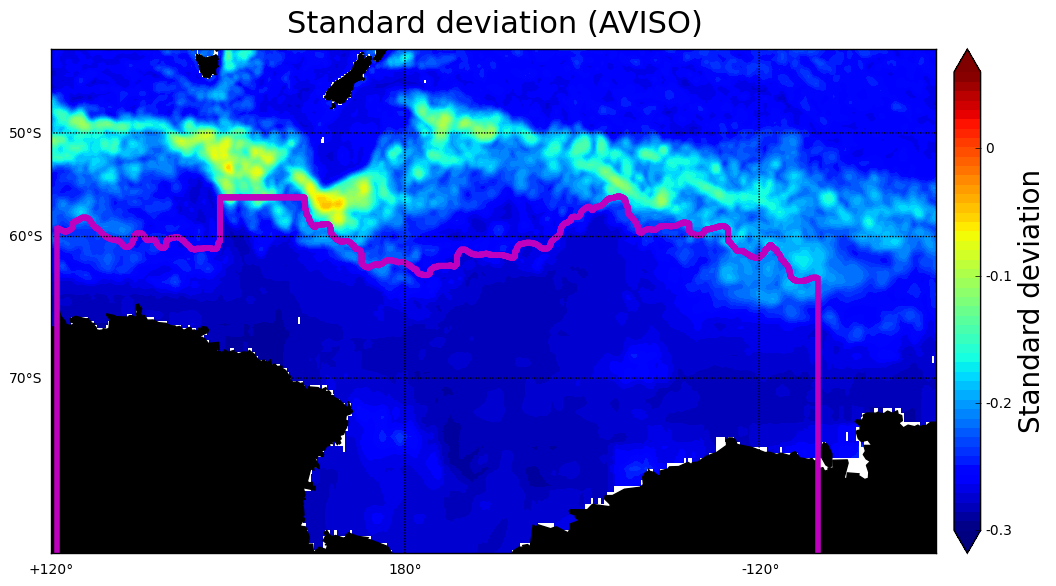

In [45]:
merc_map(np.linspace(0, 0.36, 50), Xa, Ya, std_aviso, 'Standard deviation (AVISO)', 'Standard deviation', plt.cm.jet, '/home/ebent/Final_figs/', 'std_aviso.png')

In [23]:
std_model.min()

0.0

In [24]:
std_model.max()

0.38825428

In [26]:
np.nanmin(std_aviso)

0.0

In [27]:
np.nanmax(std_aviso)

0.51399678

***

# Profiles

Could change to those longitude instead to be consistant with the .125

In [72]:
xsave[840], xsave[720]

(210.125, 180.125)

#### This is the final plot : offset is calculated for weight_mean from -66 to -40

In [96]:
plt.plot?

In [22]:
def line_plot(longitude, linewidth, title, save=False, title_save=None):
    plt.figure(figsize=(6,3.75))
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude], label='AVISO', linewidth=linewidth)
    #plt.plot(ysave[:162], mean_ssh_model[:,longitude], label='Model', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_model[:,longitude] + mean_diff_weight, label='Model + offset', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude] - mean_ssh_model[:,longitude] - mean_diff_weight, label='AVISO - (Model + offset)', linewidth=linewidth)
    plt.legend(loc='upper left', fontsize=12)
    plt.title(title, fontsize=22, y=1.02)
    plt.xlabel('Latitude', fontsize=20, labelpad=10)
    plt.ylabel('SSH [m]', fontsize=20, labelpad=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if save == True:
        plt.savefig('/home/ebent/Final_figs/' + title_save, bbox_inches='tight')

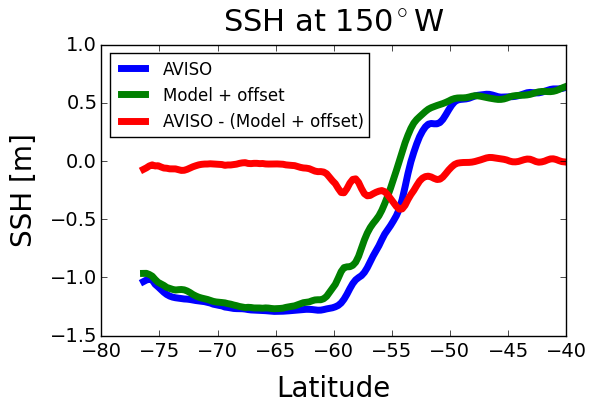

In [18]:
line_plot(longitude=840, linewidth=5, title='SSH at 150$^\circ$W', save=True, title_save='line_plot_validation.png')

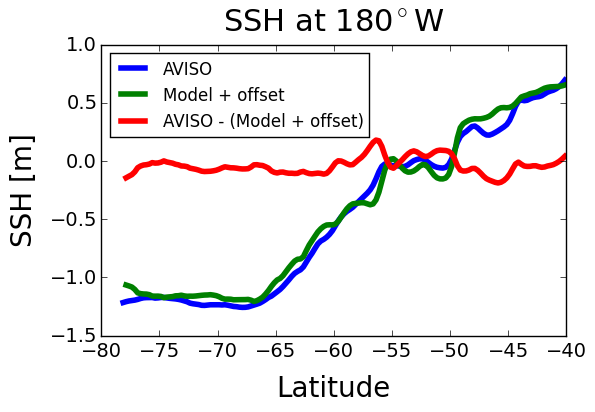

In [19]:
line_plot(longitude=720, linewidth=4, title='SSH at 180$^\circ$W')

In [15]:
def line_plot(longitude, linewidth, title, save=False, title_save=None):
    plt.figure(figsize=(6,3.75))
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude], label='AVISO', linewidth=linewidth)
    #plt.plot(ysave[:162], mean_ssh_model[:,longitude], label='Model', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_model[:,longitude] + mean_diff_weight, label='Model', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude] - mean_ssh_model[:,longitude] - mean_diff_weight, label='AVISO - Model', linewidth=linewidth)
    plt.legend(loc='upper left', fontsize=12)
    plt.title(title, fontsize=22, y=1.02)
    plt.xlabel('Latitude', fontsize=20, labelpad=10)
    plt.ylabel('SSH [m]', fontsize=20, labelpad=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if save == True:
        plt.savefig('/home/ebent/Final_figs/' + title_save, bbox_inches='tight')

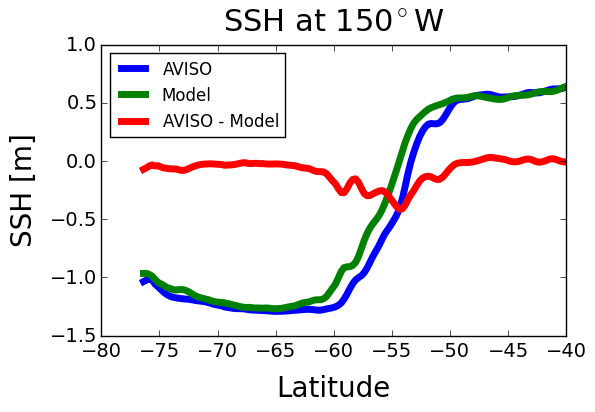

In [17]:
line_plot(longitude=840, linewidth=5, title='SSH at 150$^\circ$W', save=True, title_save='line_plot_validation.png')

In [34]:
def line_2plot(longitude, linewidth, title, save=False, title_save=None):
    #plt.figure(figsize=(6,3.75))
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude], label='AVISO', linewidth=linewidth)
    #plt.plot(ysave[:162], mean_ssh_model[:,longitude], label='Model', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_model[:,longitude] + mean_diff_weight, label='Model + offset', linewidth=linewidth)
    plt.plot(ysave[:162], mean_ssh_aviso[:,longitude] - mean_ssh_model[:,longitude] - mean_diff_weight, label='AVISO - (Model + offset)', linewidth=linewidth)
    plt.legend(loc='upper left', fontsize=12)
    plt.title(title, fontsize=22, y=1.02)
    plt.xlabel('Latitude', fontsize=20, labelpad=10)
    plt.ylabel('SSH [m]', fontsize=20, labelpad=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if save == True:
        plt.savefig('/home/ebent/Final_figs/' + title_save, bbox_inches='tight')

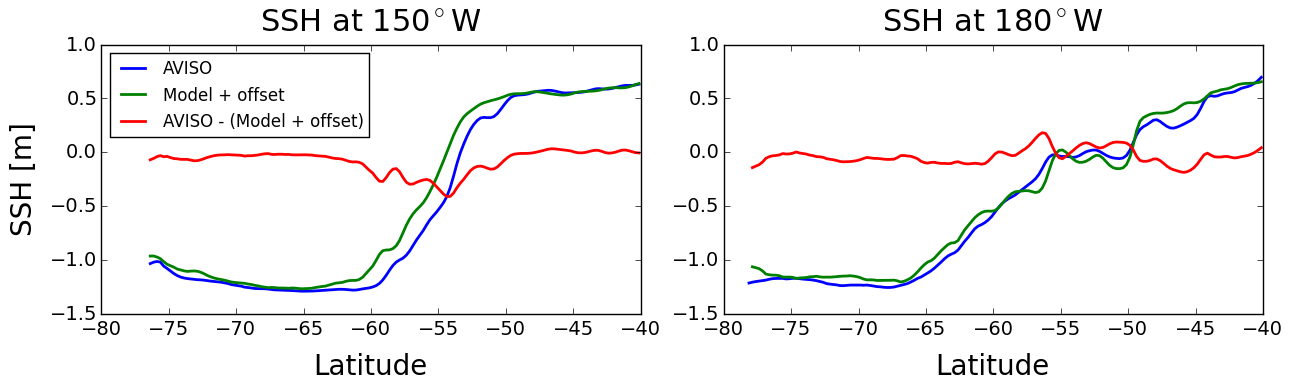

In [33]:
fig = plt.figure(figsize=(13,4))

plt.subplot(121)

longitude=840
linewidth=2
title='SSH at 150$^\circ$W'

plt.plot(ysave[:162], mean_ssh_aviso[:,longitude], label='AVISO', linewidth=linewidth)
plt.plot(ysave[:162], mean_ssh_model[:,longitude] + mean_diff_weight, label='Model + offset', linewidth=linewidth)
plt.plot(ysave[:162], mean_ssh_aviso[:,longitude] - mean_ssh_model[:,longitude] - mean_diff_weight, label='AVISO - (Model + offset)', linewidth=linewidth)
plt.legend(loc='upper left', fontsize=12)
plt.title(title, fontsize=22, y=1.02)
plt.xlabel('Latitude', fontsize=20, labelpad=10)
plt.ylabel('SSH [m]', fontsize=20, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)   
longitude=720
linewidth=2
title='SSH at 180$^\circ$W'

plt.plot(ysave[:162], mean_ssh_aviso[:,longitude], label='AVISO', linewidth=linewidth)
plt.plot(ysave[:162], mean_ssh_model[:,longitude] + mean_diff_weight, label='Model + offset', linewidth=linewidth)
plt.plot(ysave[:162], mean_ssh_aviso[:,longitude] - mean_ssh_model[:,longitude] - mean_diff_weight, label='AVISO - (Model + offset)', linewidth=linewidth)
plt.title(title, fontsize=22, y=1.02)
plt.xlabel('Latitude', fontsize=20, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.tight_layout()

plt.savefig('/home/ebent/Final_figs/' + 'two_line_plot_validation.png', dpi=300, bbox_inches='tight')